In [71]:
import os
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from run_gradient_em_attack import run_attack

In [2]:
main_folder = 'output/'
german_json_folder = os.path.join(main_folder, 'german', 'influence_data')
compas_json_folder = os.path.join(main_folder, 'compas', 'influence_data')
drug_json_folder = os.path.join(main_folder, 'drug',   'influence_data')

In [67]:
%%capture

results_parity = {}
results_accuracy = {}

datasets = ["german", "compas", "drug"]
attacks  = ["IAF", "RNAA", "RAA", "Koh", "Solans"]
epsilon = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for dataset in datasets:

    # Each dictionary contains the datasets as keys. The value of these keys is another dictionary,
    # where they keys are the different attacks. They will store the values of the different metrics
    results_parity[dataset]   = {attack: {} for attack in attacks}
    results_accuracy[dataset] = {attack: {} for attack in attacks}

    for attack in attacks:

        for eps in epsilon:

            # Retrieve results
            log_parity   = run_attack(total_grad_iter = 10000, dataset = dataset, use_slab = True, epsilon = eps, lamb = 1, method = attack, stopping_method = "Parity",   stop_after = 2, log_metrics = True, display_iter_time = True, eval_mode = True)
            log_accuracy = run_attack(total_grad_iter = 10000, dataset = dataset, use_slab = True, epsilon = eps, lamb = 1, method = attack, stopping_method = "Accuracy", stop_after = 2, log_metrics = True, display_iter_time = True, eval_mode = True)

            # Store results using Parity as the stopping method
            results_parity[dataset][attack].setdefault("test_error", []).append(log_parity['test_acc'])
            results_parity[dataset][attack].setdefault("SPD", []).append(log_parity['Parity'])
            results_parity[dataset][attack].setdefault("EOD", []).append(log_parity['E0'])

            # Store results using Accuracy as the stopping method
            results_accuracy[dataset][attack].setdefault("test_error", []).append(1 - log_accuracy['test_acc'])
            results_accuracy[dataset][attack].setdefault("SPD", []).append(log_accuracy['Parity'])
            results_accuracy[dataset][attack].setdefault("EOD", []).append(log_accuracy['E0'])


INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.1_1.0_Parity-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.1_1.0_Accuracy-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.2_1.0_Parity-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.2_1.0_Accuracy-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.3_1.0_Parity-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.3_1.0_Accuracy-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.4_1.0_Parity-checkpoint
INFO:tensorflow:Restoring parameters fro

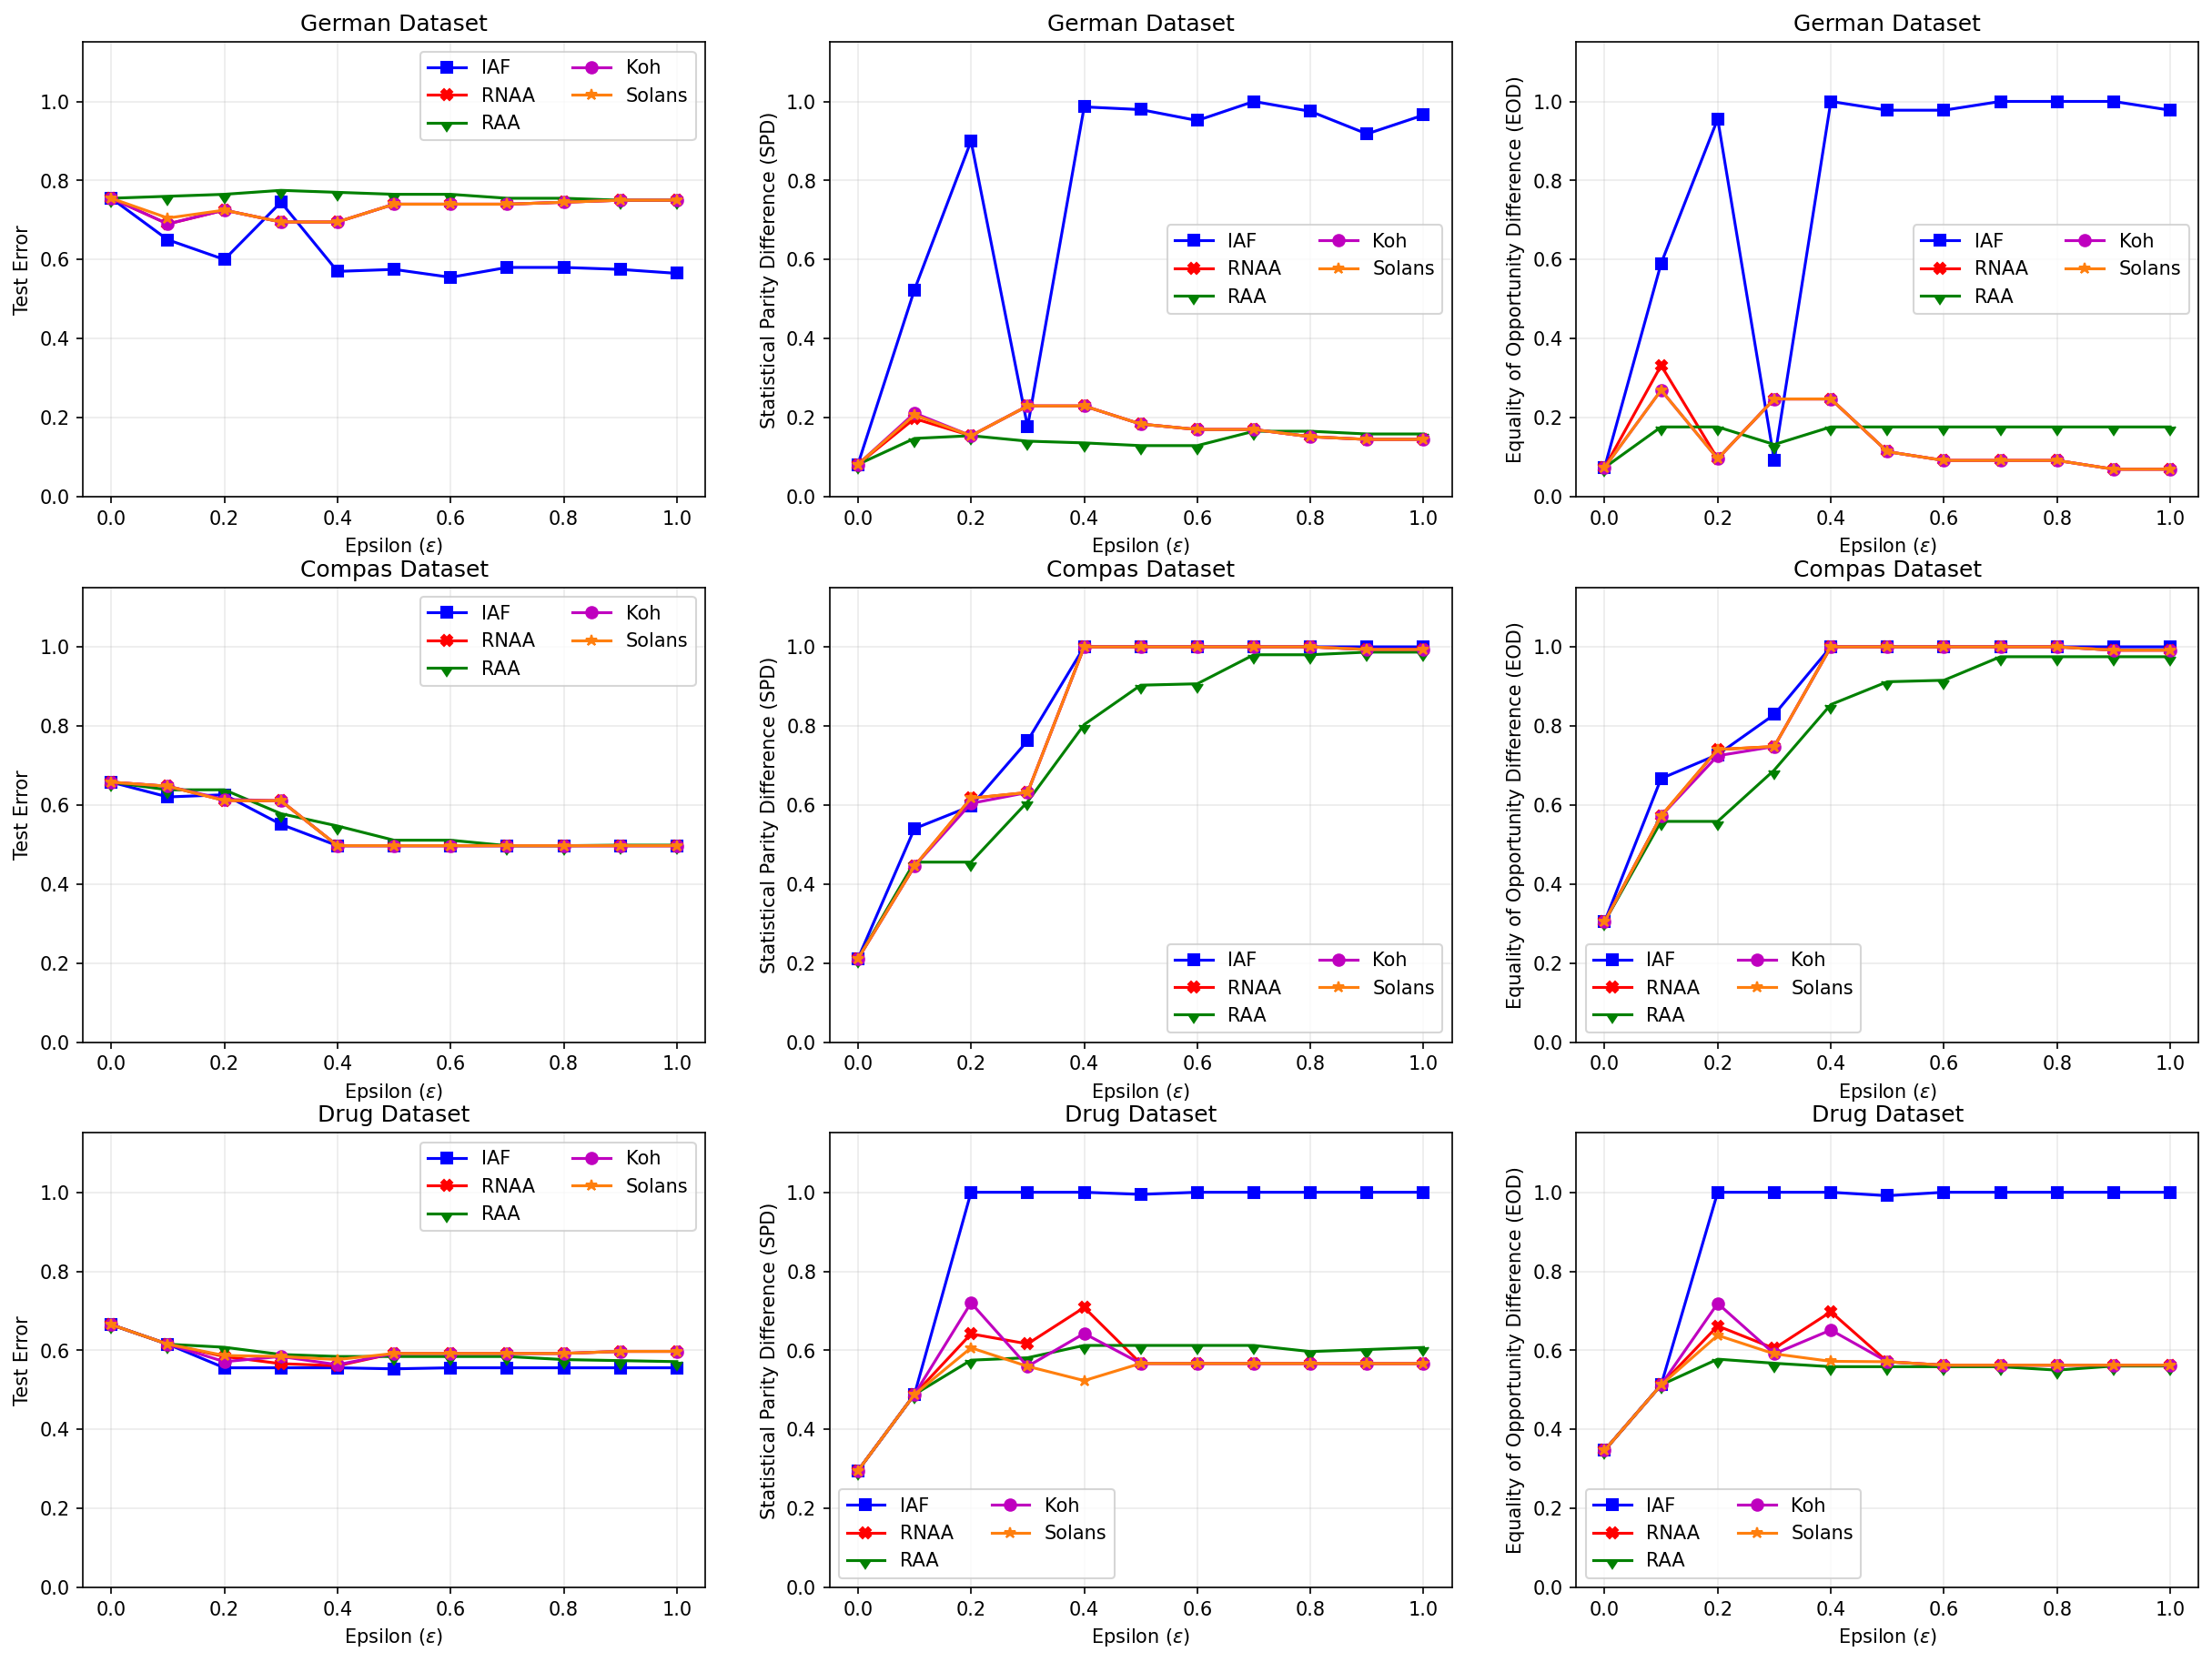

In [96]:
colors  = ['b', 'r', 'g', 'm', 'tab:orange']
markers = ['s', 'X', matplotlib.markers.CARETDOWNBASE, 'o', '*']

fig, axs = plt.subplots(3, 3, figsize=(20,15), dpi=150)
rows = [0,1,2]
cols = [0,1,2]
for row in rows:
    # Choose dataset based on the row
    if row == 0:
        dataset = 'german'
    elif row==1:
        dataset = 'compas'
    else:
        dataset = 'drug'
    
    for col in cols:
        # Choose metric to plot based on the column
        if col == 0:
            metric = 'test_error'
            y_label = 'Test Error'
        elif col==1:
            metric = 'SPD'
            y_label = 'Statistical Parity Difference (SPD)'
        else:
            metric = 'EOD'
            y_label = 'Equality of Opportunity Difference (EOD)'

        for att, c, m in zip(attacks, colors, markers):
            axs[row, col].plot(epsilon, results_parity[dataset][att][metric], label=att, color = c, marker = m)
            axs[row, col].legend(ncol=2)
            axs[row, col].set_ylim([0, 1.15])
            axs[row, col].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
            axs[row, col].grid(alpha=0.25)
            axs[row, col].title.set_text(f'{dataset.capitalize()} Dataset')
            axs[row, col].set_xlabel('Epsilon ($\epsilon$)')
            axs[row, col].set_ylabel(y_label)

Minimum accuracy:  0.51
Parity at the point of minimal accuracy:  0.8489970755733508
Actual maximal parity:  1.0


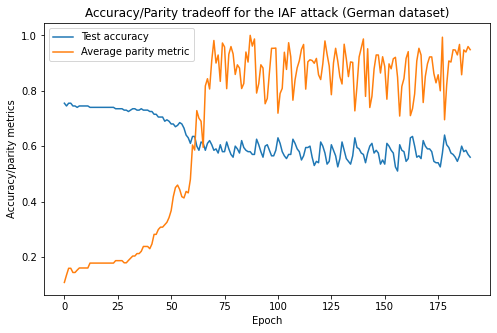

In [3]:
# Accuracy/Parity tradeoff depending on the epoch, for Parity based stopper, IAF attack
f = open(os.path.join(german_json_folder, 'german_IAF_0.5_1.0_Accuracy-checkpoint.json'))
data_parity_stopper = json.load(f)

fig, ax = plt.subplots(figsize=(8,5))
plt.title('Accuracy/Parity tradeoff for the IAF attack (German dataset)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/parity metrics')
plt.plot(data_parity_stopper['Accuracies'], label='Test accuracy')
plt.plot(data_parity_stopper['Average_Parities'], label='Average parity metric')
ax.legend()

# At the epoch with minimal accuracy, what is the value of the parity?
# What can be the actual maximal value of the parity?
min_acc_idx = int(np.where(data_parity_stopper['Accuracies']==np.min(data_parity_stopper['Accuracies']))[0])
parity_at_min_acc = data_parity_stopper['Average_Parities'][min_acc_idx]
print('Minimum accuracy: ', np.min(data_parity_stopper['Accuracies']))
print('Parity at the point of minimal accuracy: ', parity_at_min_acc)
print('Actual maximal parity: ', np.max(data_parity_stopper['Average_Parities']))

Minimum accuracy:  0.325
Parity at the point of minimal accuracy:  0.07331313676852096
Actual maximal parity:  0.24862962623350426


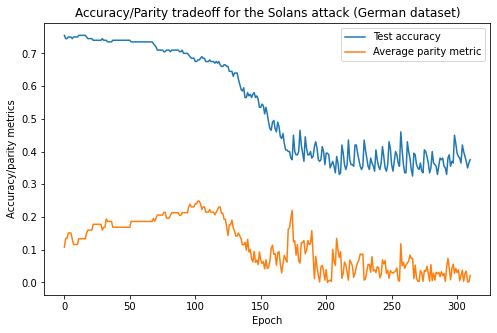

In [4]:
# Accuracy/Parity tradeoff depending on the epoch, for Parity based stopper, Solans attack
f = open(os.path.join(german_json_folder, 'german_Solans_0.5_1.0_Accuracy-checkpoint.json'))
data_parity_stopper = json.load(f)

fig, ax = plt.subplots(figsize=(8,5))
plt.title('Accuracy/Parity tradeoff for the Solans attack (German dataset)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/parity metrics')
plt.plot(data_parity_stopper['Accuracies'], label='Test accuracy')
plt.plot(data_parity_stopper['Average_Parities'], label='Average parity metric')
ax.legend()

# At the epoch with minimal accuracy, what is the value of the parity?
# What can be the actual maximal value of the parity?
min_acc_idx = int(np.where(data_parity_stopper['Accuracies']==np.min(data_parity_stopper['Accuracies']))[0])
parity_at_min_acc = data_parity_stopper['Average_Parities'][min_acc_idx]
print('Minimum accuracy: ', np.min(data_parity_stopper['Accuracies']))
print('Parity at the point of minimal accuracy: ', parity_at_min_acc)
print('Actual maximal parity: ', np.max(data_parity_stopper['Average_Parities']))

Minimum accuracy:  0.37422037422037424
Parity at the point of minimal accuracy:  0.1842176849777965
Actual maximal parity:  1.0


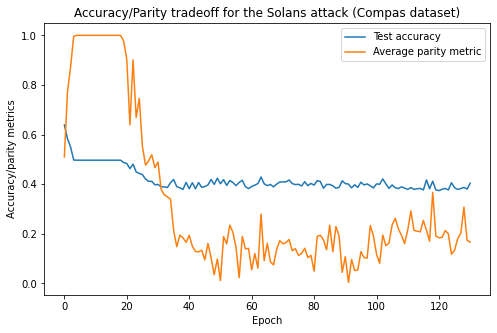

In [7]:
# Accuracy/Parity tradeoff depending on the epoch, for Parity based stopper, Solans attack
f = open(os.path.join(compas_json_folder, 'compas_Solans_0.5_1.0_Accuracy-checkpoint.json'))
data_parity_stopper = json.load(f)

fig, ax = plt.subplots(figsize=(8,5))
plt.title('Accuracy/Parity tradeoff for the Solans attack (Compas dataset)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/parity metrics')
plt.plot(data_parity_stopper['Accuracies'], label='Test accuracy')
plt.plot(data_parity_stopper['Average_Parities'], label='Average parity metric')
ax.legend()

# At the epoch with minimal accuracy, what is the value of the parity?
# What can be the actual maximal value of the parity?
min_acc_idx = int(np.where(data_parity_stopper['Accuracies']==np.min(data_parity_stopper['Accuracies']))[0])
parity_at_min_acc = data_parity_stopper['Average_Parities'][min_acc_idx]
print('Minimum accuracy: ', np.min(data_parity_stopper['Accuracies']))
print('Parity at the point of minimal accuracy: ', parity_at_min_acc)
print('Actual maximal parity: ', np.max(data_parity_stopper['Average_Parities']))

In [ ]:
# Different types of attacks. The last two are the baselines
method = ['IAF', 'RAA', 'NRAA', 'Koh', 'Solans']

# List of different datasets to use
dataset = ['german', 'compas', 'drug']

# List of hyperparameters
eps = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
lamb = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


In [ ]:
os.system("run_gradient_em_attack.py --total_grad_iter 10000 --dataset eval("compas") --use_slab --epsilon 0.5 --method eval("IAF") --sensitive_feature_idx 0 --sensitive_attr_filename eval("compas_group_label.npz") --arg1 {} --arg2 {}".format(a1, arg))

In [ ]:
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
lambdas =  [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
datasets = ["compas"]                # ["german", "compas", "drug"]
attacks =  ["IAF"]                   # ["IAF", "RAA", "RNAA", "Koh", "Solans"]
stopping_methods = ["Parity"]        # ["Parity", "Accuracy"]


for eps in epsilons: 
    for lamb in lambdas: 
        for dataset in datasets:
            for attack in attacks:
                for stopping_method in stopping_methods:

                    # Print run information in the terminal
                    print("\n============================================")
                    print(f"Run parameters: \n - Dataset: {dataset}\n - Attack: {attack}\n - Stopping method: {stopping_method}\n - Epsilon: {eps}, Lambda: {lamb}")
                    print("============================================")
                    
                    os.system(f"python -u run_gradient_em_attack.py --total_grad_iter 10000 --dataset {dataset} --use_slab --epsilon {eps} --lamb {lamb} --method {attack} --sensitive_attr_filename {dataset}_group_label.npz --stopping_method {stopping_methods} --stop_after 5\n")